In [138]:
import os
import time

import pandas as pd
import numpy as np
import scipy.stats as sts
import matplotlib.pyplot as plt
import seaborn as sns

import googlemaps
from difflib import SequenceMatcher

import pystan
from sklearn.cluster import KMeans

# !!THINGS TO DO, BRAH!!
2. K-means visualization
3. Write assumptions
4. Clusters map with mean on there

## High-level model definition
To model prices of common groceries, we will take several assumptions:
1. Base prices of products are independently distributed (banana prices are not dependent on apples)
2. Multiplier of one store in two distant locations can vary
3. Multiplier of location can vary in two different stores
4. Two same stores within 2 km of each other will have same prices (because otherwise people can just by default go to the cheaper store, and it just doesn't make sense economically)
5. Some prices would be not full like 2.95 or 2.99, and in data collection some people will round that to 3

Based on the assumptions, we can then specify the model:
1. From assumptions 1-3, we then need unique parametrization for each triplet of product, store, location
2. From assumption 4, we can merge stores closeby into one location (cluster) via k-means
3. From assumption 5, we need an error term to account for the price rounding

<img src="LBA.png" />

Reasoning for distribution choices:
1. For product base price, we use a gamma distribution because it is non-negative and continuous. It has slightly fat right tail, which can account for super pricey fancy apples
2. For the store and location multipliers, we use a trimmed normal distribution to be able to set the mean at 1 and variance symmetrical. Symmetrical variance shows that the average price would have multiplier 1, and there are as many more expensive and cheaper stores
3. For the likelihood, we use the normal distribution with mean of product of base price with store and location multipliers and a standard deviation $\epsilon$ to account for data rounding

## Load and clean dataset

In [2]:
ROOT = './lba_data'
groceries_data = pd.read_csv(os.path.join(ROOT, 'groceries_data.csv'), header=1)
groceries_data.head()

Timestamp                   Email Address         Your name  \
0                  NaN                             NaN               NaN   
1  10/28/2019 13:14:59  brian.swanberg@minerva.kgi.edu    Brian Swanberg   
2  10/29/2019 14:19:19    emma.stiefel@minerva.kgi.edu      Emma Stiefel   
3  10/29/2019 21:22:30            taha@minerva.kgi.edu              Taha   
4  10/30/2019 16:20:11     michaelchen@minerva.kgi.edu  Michael Hao Chen   

  Grocery store             Grocery store street address  \
0           NaN                                      NaN   
1          ALDI                    Rummelsburger Str. 98   
2          REWE                   Karl-Marx-Straße 92-98   
3          ALDI  Hermannstraße 72, 12049 Berlin, Germany   
4          Lidl                  Lidl, Leipziger Str. 42   

   Product 1 quantity (kg)  Product 1 price (€)  Product 2 quantity (kg)  \
0                      NaN                  NaN                      NaN   
1                     0.88                 2.20                     1.00   
2                     1.00                 2.49                     1.00   
3                     1.00                 2.99                     1.00   
4                     1.00                 1.79                     0.75   

   Product 2 price (€)  Product 3 quantity (kg)          ...            \
0                  NaN                      NaN          ...             
1                 1.88                      0.6          ...             
2                 1.49                      1.0          ...             
3                 1.79                      0.8          ...             
4                 1.99                      0.8          ...             

   Product 2 quantity (count)  Product 2 price (€).8  \
0                         NaN                    NaN   
1                         6.0                   1.59   
2                         1.0                   0.25   
3                        10.0                   1.19   
4                        10.0                   1.69   

   Product 3 quantity (count)  Product 3 price (€).8  \
0                         NaN                    NaN   
1                        10.0                   1.59   
2                         6.0                   1.59   
3                         6.0                   1.59   
4                        10.0                   2.65   

   Product 1 quantity (kg).7  Product 1 price (€).9  \
0                        NaN                    NaN   
1                        0.6                   3.99   
2                        1.0                  13.90   
3                        0.6                   3.99   
4                        0.6                   3.99   

   Product 2 quantity (kg).7  Product 2 price (€).9  \
0                        NaN                    NaN   
1                        1.0                   5.99   
2                        1.0                   9.99   
3                        1.0                   5.99   
4                        0.4                   2.79   

   Product 3 quantity (kg).7  Product 3 price (€).9  
0                        NaN                    NaN  
1                        NaN                    NaN  
2                       1.00                   9.98  
3                       0.35                   3.99  
4                        NaN                    NaN  

[5 rows x 65 columns]

There are several things we need to do to clean and format the data:
1. Drop false entries (e.g., row 0)
2. Timestamp is not relevant here (data gathering time is too close together to model change in price over time)
3. Email addresses and student names are not relevant (location can be inferred from address)
4. Rename all columns to allow for neat iteration (`qnt[i][j]`, `price[i][j]` for `i` in count of products (10) and `j` in count of brands (3))
5. Normalize all the prices based on count unit (e.g., 1 kg or 1 liter) and remove old columns
6. Reformat all grocery store names (all lowercase, underscore instead of spaces) and merge same stores with varying name to one name (e.g., 'Tesco Express' is the same as 'Tesco')

In [3]:
# 1

groceries_data.dropna(how='all', inplace=True)
groceries_data.reset_index(inplace=True, drop=True)
groceries_data.head(3)

Timestamp                   Email Address       Your name  \
0  10/28/2019 13:14:59  brian.swanberg@minerva.kgi.edu  Brian Swanberg   
1  10/29/2019 14:19:19    emma.stiefel@minerva.kgi.edu    Emma Stiefel   
2  10/29/2019 21:22:30            taha@minerva.kgi.edu            Taha   

  Grocery store             Grocery store street address  \
0          ALDI                    Rummelsburger Str. 98   
1          REWE                   Karl-Marx-Straße 92-98   
2          ALDI  Hermannstraße 72, 12049 Berlin, Germany   

   Product 1 quantity (kg)  Product 1 price (€)  Product 2 quantity (kg)  \
0                     0.88                 2.20                      1.0   
1                     1.00                 2.49                      1.0   
2                     1.00                 2.99                      1.0   

   Product 2 price (€)  Product 3 quantity (kg)          ...            \
0                 1.88                      0.6          ...             
1                 1.49                      1.0          ...             
2                 1.79                      0.8          ...             

   Product 2 quantity (count)  Product 2 price (€).8  \
0                         6.0                   1.59   
1                         1.0                   0.25   
2                        10.0                   1.19   

   Product 3 quantity (count)  Product 3 price (€).8  \
0                        10.0                   1.59   
1                         6.0                   1.59   
2                         6.0                   1.59   

   Product 1 quantity (kg).7  Product 1 price (€).9  \
0                        0.6                   3.99   
1                        1.0                  13.90   
2                        0.6                   3.99   

   Product 2 quantity (kg).7  Product 2 price (€).9  \
0                        1.0                   5.99   
1                        1.0                   9.99   
2                        1.0                   5.99   

   Product 3 quantity (kg).7  Product 3 price (€).9  
0                        NaN                    NaN  
1                       1.00                   9.98  
2                       0.35                   3.99  

[3 rows x 65 columns]

In [4]:
# 2 & 3

groceries_data.drop(columns=['Timestamp', 'Email Address', 'Your name'], inplace=True)
groceries_data.head(3)

Grocery store             Grocery store street address  \
0          ALDI                    Rummelsburger Str. 98   
1          REWE                   Karl-Marx-Straße 92-98   
2          ALDI  Hermannstraße 72, 12049 Berlin, Germany   

   Product 1 quantity (kg)  Product 1 price (€)  Product 2 quantity (kg)  \
0                     0.88                 2.20                      1.0   
1                     1.00                 2.49                      1.0   
2                     1.00                 2.99                      1.0   

   Product 2 price (€)  Product 3 quantity (kg)  Product 3 price (€)  \
0                 1.88                      0.6                 1.89   
1                 1.49                      1.0                 2.49   
2                 1.79                      0.8                 1.89   

   Product 1 quantity (kg).1  Product 1 price (€).1          ...            \
0                        1.0                   1.69          ...             
1                        1.0                   0.99          ...             
2                        1.0                   1.15          ...             

   Product 2 quantity (count)  Product 2 price (€).8  \
0                         6.0                   1.59   
1                         1.0                   0.25   
2                        10.0                   1.19   

   Product 3 quantity (count)  Product 3 price (€).8  \
0                        10.0                   1.59   
1                         6.0                   1.59   
2                         6.0                   1.59   

   Product 1 quantity (kg).7  Product 1 price (€).9  \
0                        0.6                   3.99   
1                        1.0                  13.90   
2                        0.6                   3.99   

   Product 2 quantity (kg).7  Product 2 price (€).9  \
0                        1.0                   5.99   
1                        1.0                   9.99   
2                        1.0                   5.99   

   Product 3 quantity (kg).7  Product 3 price (€).9  
0                        NaN                    NaN  
1                       1.00                   9.98  
2                       0.35                   3.99  

[3 rows x 62 columns]

In [5]:
# 4

num_of_products = 10
num_of_brands = 3

new_cols = ['store', 'address']
for i in range(num_of_products):
    for j in range(num_of_brands):
        new_cols.append('qnt[{0}][{1}]'.format(i, j))
        new_cols.append('price[{0}][{1}]'.format(i, j))

groceries_data.columns = new_cols
groceries_data.head(3)

store                                  address  qnt[0][0]  price[0][0]  \
0  ALDI                    Rummelsburger Str. 98       0.88         2.20   
1  REWE                   Karl-Marx-Straße 92-98       1.00         2.49   
2  ALDI  Hermannstraße 72, 12049 Berlin, Germany       1.00         2.99   

   qnt[0][1]  price[0][1]  qnt[0][2]  price[0][2]  qnt[1][0]  price[1][0]  \
0        1.0         1.88        0.6         1.89        1.0         1.69   
1        1.0         1.49        1.0         2.49        1.0         0.99   
2        1.0         1.79        0.8         1.89        1.0         1.15   

      ...       qnt[8][1]  price[8][1]  qnt[8][2]  price[8][2]  qnt[9][0]  \
0     ...             6.0         1.59       10.0         1.59        0.6   
1     ...             1.0         0.25        6.0         1.59        1.0   
2     ...            10.0         1.19        6.0         1.59        0.6   

   price[9][0]  qnt[9][1]  price[9][1]  qnt[9][2]  price[9][2]  
0         3.99        1.0         5.99        NaN          NaN  
1        13.90        1.0         9.99       1.00         9.98  
2         3.99        1.0         5.99       0.35         3.99  

[3 rows x 62 columns]

In [6]:
# 5

for i in range(num_of_products):
    for j in range(num_of_brands):
        cur_qnt = 'qnt[{0}][{1}]'.format(i, j)
        cur_price = 'price[{0}][{1}]'.format(i, j)

        try: # already removed
            groceries_data['price_norm[{0}][{1}]'.format(i, j)] =\
                groceries_data[cur_price] / groceries_data[cur_qnt]
        
            groceries_data.drop(columns=[cur_qnt, cur_price], inplace=True)
        except KeyError:
            pass
        
groceries_data.head(3)

store                                  address  price_norm[0][0]  \
0  ALDI                    Rummelsburger Str. 98              2.50   
1  REWE                   Karl-Marx-Straße 92-98              2.49   
2  ALDI  Hermannstraße 72, 12049 Berlin, Germany              2.99   

   price_norm[0][1]  price_norm[0][2]  price_norm[1][0]  price_norm[1][1]  \
0              1.88            3.1500              1.69              0.99   
1              1.49            2.4900              0.99              1.69   
2              1.79            2.3625              1.15              1.69   

   price_norm[1][2]  price_norm[2][0]  price_norm[2][1]        ...         \
0               NaN          3.523077              2.98        ...          
1             1.590          6.900000              4.58        ...          
2             1.495          3.580000              1.99        ...          

   price_norm[6][2]  price_norm[7][0]  price_norm[7][1]  price_norm[7][2]  \
0              0.99              5.56              6.36              9.56   
1              0.79              5.56              5.56              9.56   
2              0.99              9.56              5.16              5.16   

   price_norm[8][0]  price_norm[8][1]  price_norm[8][2]  price_norm[9][0]  \
0          0.119000             0.265             0.159              6.65   
1          0.281667             0.250             0.265             13.90   
2          0.159000             0.119             0.265              6.65   

   price_norm[9][1]  price_norm[9][2]  
0              5.99               NaN  
1              9.99              9.98  
2              5.99             11.40  

[3 rows x 32 columns]

In [7]:
# 6 
groceries_data['store'] = groceries_data['store'].str.lower()
groceries_data['store'].unique() # see what groceries there are

array(['aldi', 'rewe', 'lidl', 'tesco express', 'edeka',
       'waitrose & partners', 'safeway', 'waitrose', 'lotte mart',
       'tesco', "sainsbury's", 'waitrose & partners ', "sainsbury's ",
       'sainsbury', 'sainsbury’s ', 'waitrose & partners islington',
       'tesco '], dtype=object)

In [8]:
all_stores = ['aldi', 'rewe', 'lidl', 'edeka', 'tesco', 'waitrose', 'safeway', 'lotte', 'sainsbury']
groceries_data['store'] = [all_stores[
    np.argmax([ # finding closest matches to the "reference" store names
        SequenceMatcher(None, store, store_ref).ratio() 
        for store_ref in all_stores])]
    for store in groceries_data['store']]
groceries_data.head(3)

store                                  address  price_norm[0][0]  \
0  aldi                    Rummelsburger Str. 98              2.50   
1  rewe                   Karl-Marx-Straße 92-98              2.49   
2  aldi  Hermannstraße 72, 12049 Berlin, Germany              2.99   

   price_norm[0][1]  price_norm[0][2]  price_norm[1][0]  price_norm[1][1]  \
0              1.88            3.1500              1.69              0.99   
1              1.49            2.4900              0.99              1.69   
2              1.79            2.3625              1.15              1.69   

   price_norm[1][2]  price_norm[2][0]  price_norm[2][1]        ...         \
0               NaN          3.523077              2.98        ...          
1             1.590          6.900000              4.58        ...          
2             1.495          3.580000              1.99        ...          

   price_norm[6][2]  price_norm[7][0]  price_norm[7][1]  price_norm[7][2]  \
0              0.99              5.56              6.36              9.56   
1              0.79              5.56              5.56              9.56   
2              0.99              9.56              5.16              5.16   

   price_norm[8][0]  price_norm[8][1]  price_norm[8][2]  price_norm[9][0]  \
0          0.119000             0.265             0.159              6.65   
1          0.281667             0.250             0.265             13.90   
2          0.159000             0.119             0.265              6.65   

   price_norm[9][1]  price_norm[9][2]  
0              5.99               NaN  
1              9.99              9.98  
2              5.99             11.40  

[3 rows x 32 columns]

## Location clustering

In [9]:
with open('/Users/Munchic/.api-keys/gcp.txt') as myfile:
      key = myfile.read().replace('\n', '')
gmaps = googlemaps.Client(key=key)

As discussed earlier, we would like to cluster same stores into one locality:
1. Find latitude and longitude locations of stores
2. Visualize each store's locations and define number of clusters, `k_i`, per store
3. Fit k-means for each store, assign cluster for each store and save cluster centroids
4. Visualize cluster regions on top of store locations to validate

In [10]:
# 1
all_locs = []
# geocoding breaks on these ones haha
address_mapping = {
    '100 East Rd.': '100 East Rd., London',
    'EDEKA, Straßburger Str. 9a-b': 'Straßburger Str. 9a-b'
}

for address in groceries_data['address']:
    if address in address_mapping:
        address = address_mapping[address]
        
    all_locs.append(tuple(gmaps.geocode(address)[0]['geometry']['location'].values()))

In [11]:
groceries_data['lat'] = np.array(all_locs)[:, 0] # latitudes
groceries_data['lon'] = np.array(all_locs)[:, 1] # longitudes
groceries_data.head(3)

store                                  address  price_norm[0][0]  \
0  aldi                    Rummelsburger Str. 98              2.50   
1  rewe                   Karl-Marx-Straße 92-98              2.49   
2  aldi  Hermannstraße 72, 12049 Berlin, Germany              2.99   

   price_norm[0][1]  price_norm[0][2]  price_norm[1][0]  price_norm[1][1]  \
0              1.88            3.1500              1.69              0.99   
1              1.49            2.4900              0.99              1.69   
2              1.79            2.3625              1.15              1.69   

   price_norm[1][2]  price_norm[2][0]  price_norm[2][1]    ...      \
0               NaN          3.523077              2.98    ...       
1             1.590          6.900000              4.58    ...       
2             1.495          3.580000              1.99    ...       

   price_norm[7][1]  price_norm[7][2]  price_norm[8][0]  price_norm[8][1]  \
0              6.36              9.56          0.119000             0.265   
1              5.56              9.56          0.281667             0.250   
2              5.16              5.16          0.159000             0.119   

   price_norm[8][2]  price_norm[9][0]  price_norm[9][1]  price_norm[9][2]  \
0             0.159              6.65              5.99               NaN   
1             0.265             13.90              9.99              9.98   
2             0.265              6.65              5.99             11.40   

         lat        lon  
0  52.499561  13.495014  
1  52.479877  13.435877  
2  52.474060  13.427420  

[3 rows x 34 columns]

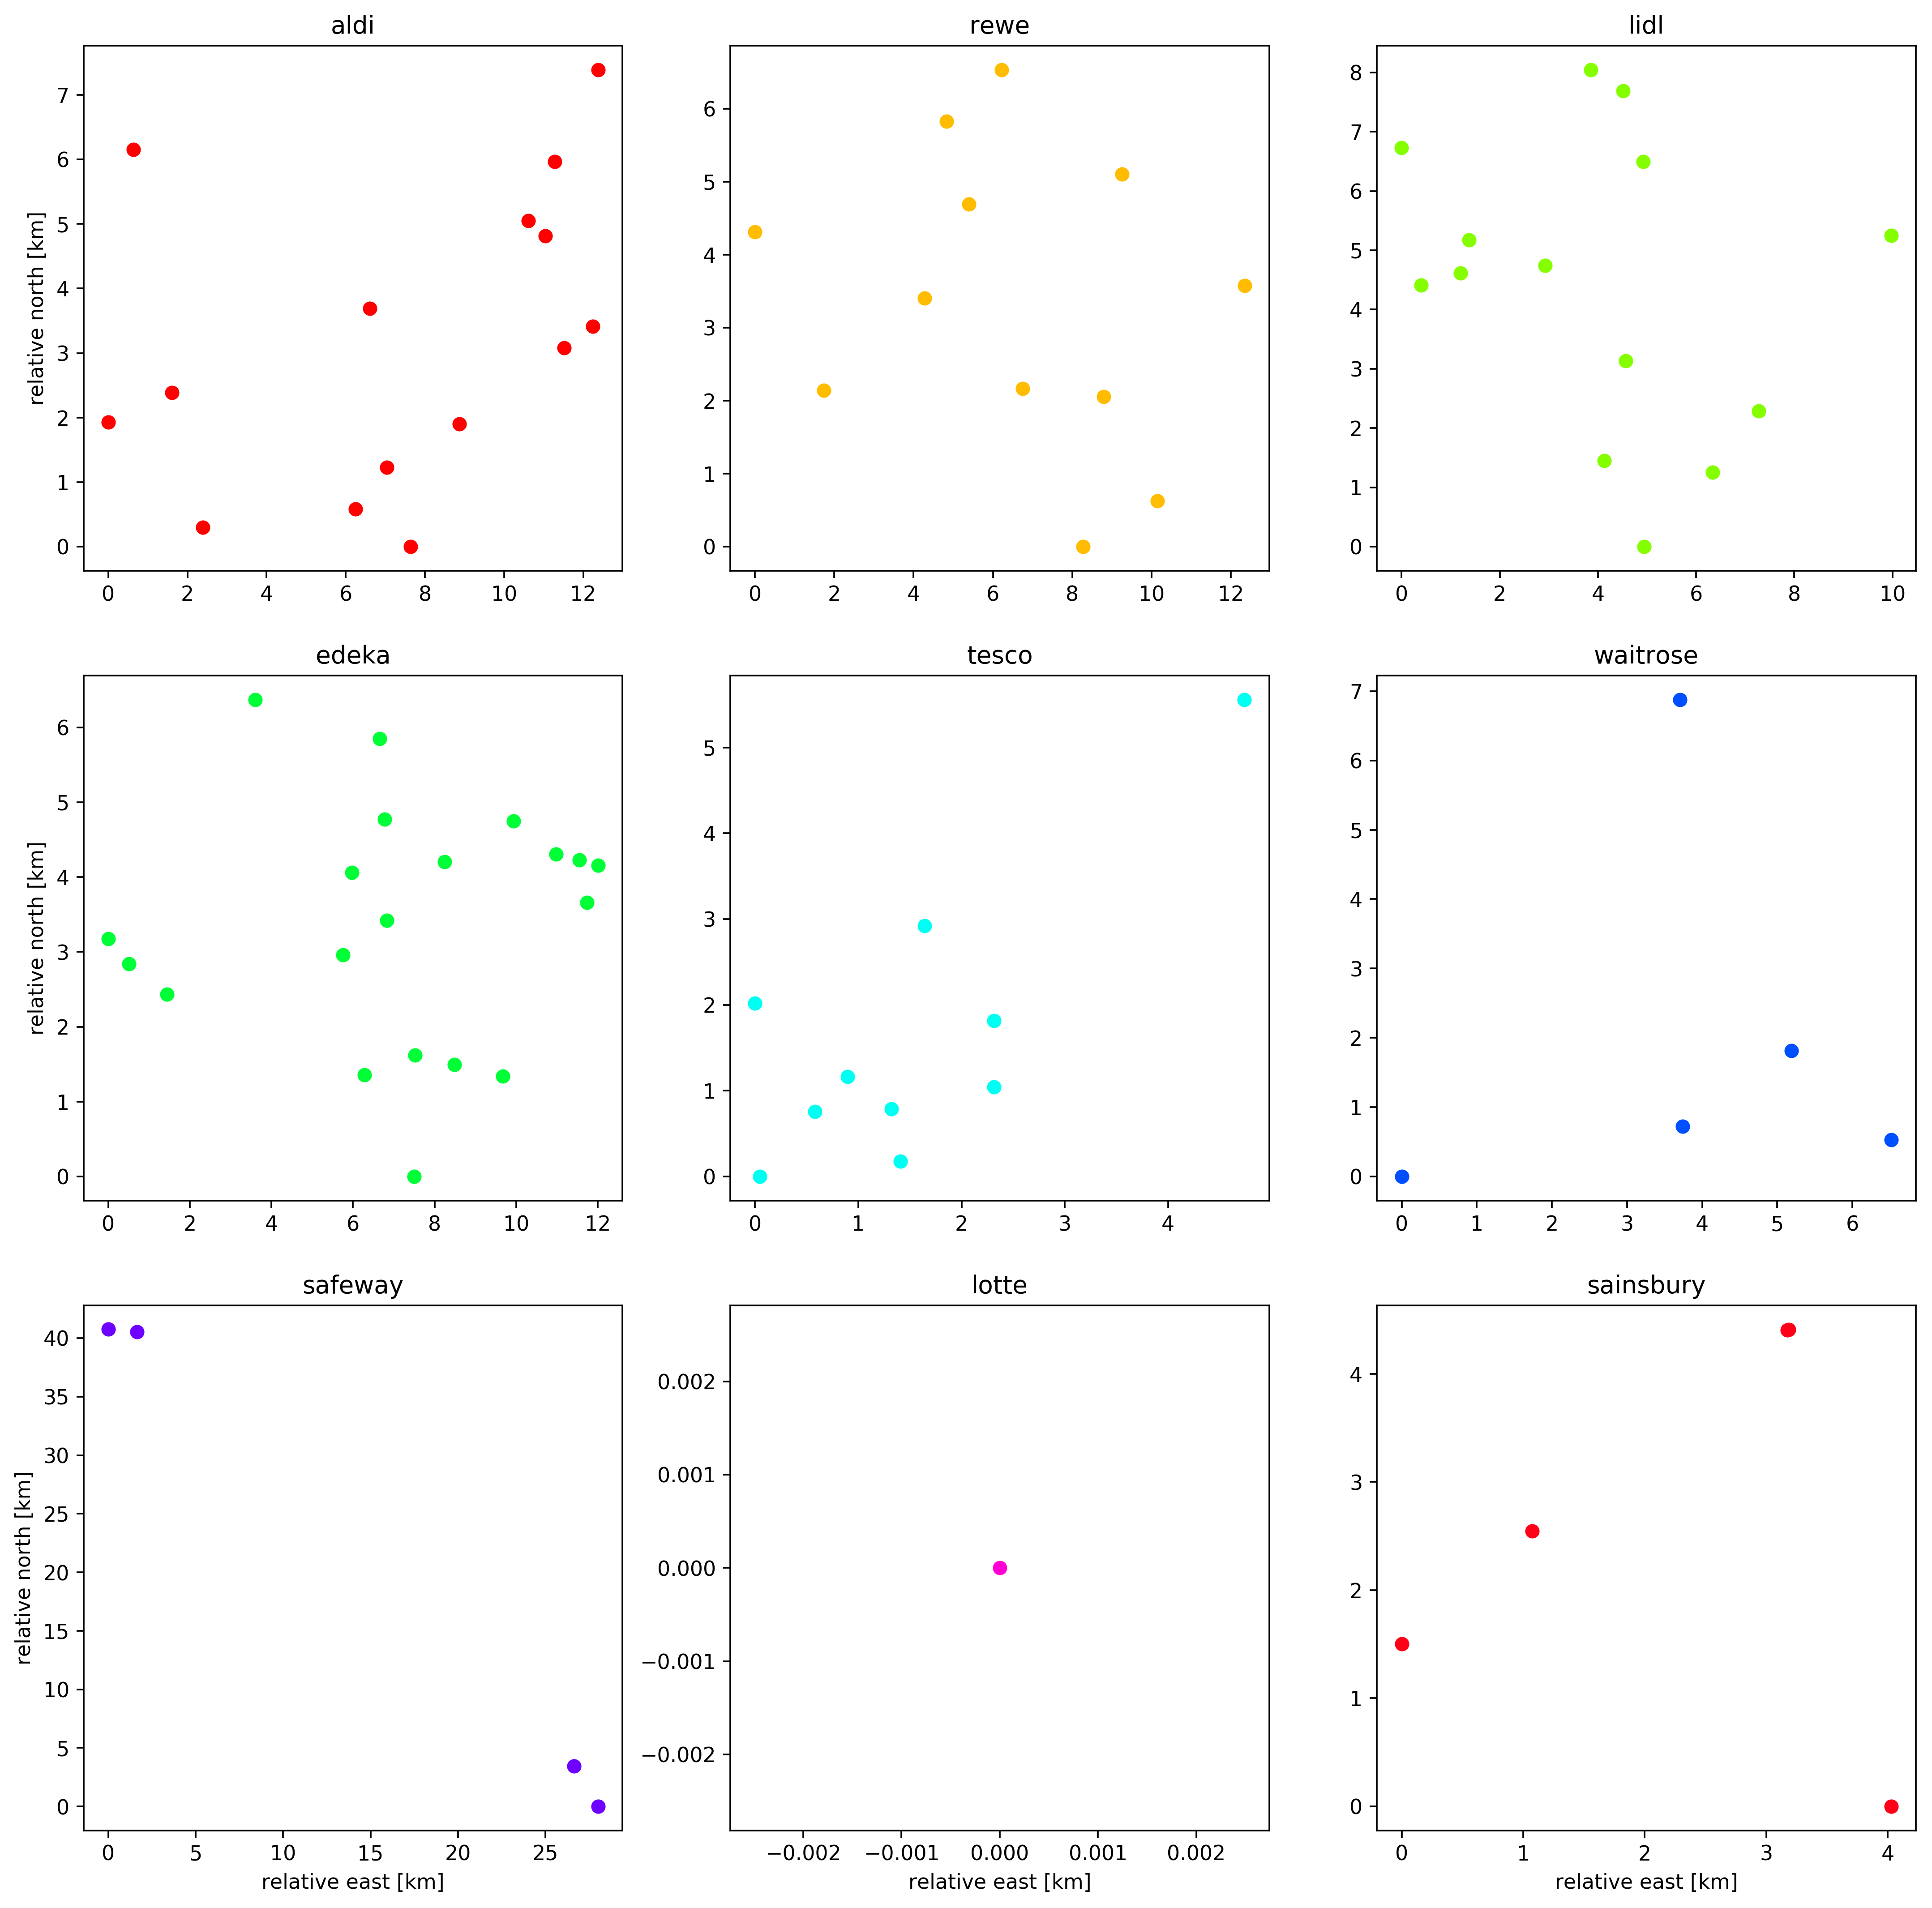

In [12]:
# 2

# approximate conversion of degrees of lat, lon into km, source:
# https://gis.stackexchange.com/questions/142326/calculating-longitude-length-in-miles
KM_IN_LAT = 111
KM_IN_LON = 88.6

plt.figure(figsize=(16, 16), dpi=330)
color_map = plt.cm.get_cmap('hsv', len(all_stores))

for plot_idx, store in enumerate(all_stores):
    all_entries_of_store = (groceries_data['store'] == store)
    lats = groceries_data[all_entries_of_store]['lat']
    lons = groceries_data[all_entries_of_store]['lon']
    
    # convert to relative distances in km for easier interpretation
    north_km = (lats - min(lats)) * KM_IN_LAT 
    east_km = (lons - min(lons)) * KM_IN_LON
    
    plt.subplot(3, 3, plot_idx + 1)
    plt.title(store)
    plt.scatter(east_km, north_km, color=color_map(plot_idx))
    if plot_idx % 3 == 0:
        plt.ylabel('relative north [km]')
    if plot_idx >= 6:
        plt.xlabel('relative east [km]')

In [13]:
# looking at visualizations, we assign how many clusters we need per store
num_cls_per_store = {
    'aldi': 6,
    'rewe': 4,
    'lidl': 4,
    'edeka': 5,
    'tesco': 3,
    'waitrose': 3,
    'safeway': 2,
    'lotte': 1,
    'sainsbury': 3
} 

In [14]:
# 3

# create placeholder for cluster assignment
groceries_data['cluster'] = np.nan * groceries_data.shape[0]

for store in all_stores:
    all_entries_of_store = (groceries_data['store'] == store)
    lats = groceries_data[all_entries_of_store]['lat']
    lons = groceries_data[all_entries_of_store]['lon']
    locs = list(zip(lats, lons))
    
    kmeans = KMeans(n_clusters=num_cls_per_store[store])
    kmeans.fit(locs)
    
    cl_locs = kmeans.cluster_centers_ # cluster centroid locations
    centroids_df = pd.DataFrame({'lat': cl_locs[:, 0], 'lon': cl_locs[:, 1]})
    centroids_df.to_csv(os.path.join(ROOT, '{}_centroids.csv'.format(store)), index=False)
    
    clusters = ['{0}_centroids[{1}]'.format(store, label) for label in kmeans.labels_]
    cluster_assignment = pd.DataFrame({'cluster': clusters}, index=groceries_data[all_entries_of_store].index)
    groceries_data.update(cluster_assignment)

In [15]:
groceries_data.head(3)

store                                  address  price_norm[0][0]  \
0  aldi                    Rummelsburger Str. 98              2.50   
1  rewe                   Karl-Marx-Straße 92-98              2.49   
2  aldi  Hermannstraße 72, 12049 Berlin, Germany              2.99   

   price_norm[0][1]  price_norm[0][2]  price_norm[1][0]  price_norm[1][1]  \
0              1.88            3.1500              1.69              0.99   
1              1.49            2.4900              0.99              1.69   
2              1.79            2.3625              1.15              1.69   

   price_norm[1][2]  price_norm[2][0]  price_norm[2][1]        ...          \
0               NaN          3.523077              2.98        ...           
1             1.590          6.900000              4.58        ...           
2             1.495          3.580000              1.99        ...           

   price_norm[7][2]  price_norm[8][0]  price_norm[8][1]  price_norm[8][2]  \
0              9.56          0.119000             0.265             0.159   
1              9.56          0.281667             0.250             0.265   
2              5.16          0.159000             0.119             0.265   

   price_norm[9][0]  price_norm[9][1]  price_norm[9][2]        lat        lon  \
0              6.65              5.99               NaN  52.499561  13.495014   
1             13.90              9.99              9.98  52.479877  13.435877   
2              6.65              5.99             11.40  52.474060  13.427420   

             cluster  
0  aldi_centroids[4]  
1  rewe_centroids[0]  
2  aldi_centroids[2]  

[3 rows x 35 columns]

## Define Stan model

To find posterior distributions of base prices, store and location multipliers, we need the following:
1. Define Stan model
2. Define prior hyperparameters for products
3. Iteratively, for each combination of product, store, location -> feed data to Stan model
4. Show preliminary results

In [63]:
# 1

grocery_price_model =\
"""
functions {
    real actual_price_lpdf(real ap, real bp, real st_mult, real loc_mult, real epsilon) {
        return normal_lpdf(ap | bp * st_mult * loc_mult, epsilon);
    }
}

data {  
    int<lower=1> num_obs; // number of observations per product
    real<lower=0> price[num_obs]; // price for each observation
    
    // prior hyperparams for base price
    real<lower=0> alpha_bp;
    real<lower=0> beta_bp;
    
    // prior hyperparams for store multiplier
    real<lower=0> mu_st_mult;
    real<lower=0> sigma_st_mult;
    
    // prior hyperparams for location multiplier
    real<lower=0> mu_loc_mult;
    real<lower=0> sigma_loc_mult;
    
    real<lower=0> epsilon; // standard error
}

parameters {
    real<lower=0> bp; // base price of product
    real<lower=0> st_mult; // multiplier of store
    real<lower=0> loc_mult; // multiplier of location
}

model {
    bp ~ gamma(alpha_bp, beta_bp);  // prior over base price
    st_mult ~ normal(mu_st_mult, sigma_st_mult); // prior over store multiplier
    loc_mult ~ normal(mu_loc_mult, sigma_loc_mult); // prior over location multiplier
    
    for (i in 1:num_obs) {
        price[i] ~ actual_price(bp, st_mult, loc_mult, epsilon); // likelihood function
    }
}
"""

In [76]:
stan_model = pystan.StanModel(model_code=grocery_price_model)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_4e1ef589ed673b62bc3d0d8a1b2a79c8 NOW.


In [108]:
# check if model converges on mock data
stan_data = {
    "num_obs": 5,
    "price": [4, 4.5, 3, 6, 8],
    "alpha_bp": 2.0,
    "beta_bp": 1.5,
    "mu_st_mult": 1.0,
    "sigma_st_mult": 0.3,
    "mu_loc_mult": 1.0,
    "sigma_loc_mult": 0.5,
    "epsilon": 0.05
}

stan_results = stan_model.sampling(data=stan_data)
print(stan_results)

Inference for Stan model: anon_model_4e1ef589ed673b62bc3d0d8a1b2a79c8.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

           mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
bp         3.02    0.03   0.89   1.74   2.39   2.88   3.51    5.2    935    1.0
st_mult    1.22  7.5e-3   0.25   0.74   1.04   1.21   1.39   1.72   1143    1.0
loc_mult   1.53    0.01   0.38   0.87   1.26    1.5   1.76    2.4    962    1.0
lp__      -3033    0.04   1.28  -3036  -3033  -3033  -3032  -3032    963   1.01

Samples were drawn using NUTS at Mon Nov 11 22:13:31 2019.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


In [109]:
# 2

# products defined in the assignment, in order of dataframe
all_products = ['apple', 'banana', 'tomato', 'potato', 'flour', 'rice', 'milk', 'butter', 'eggs', 'chicken']

# priors for product prices
alpha_bps = [3, 2, 2, 1.5, 0.5, 1, 1, 1.5, 3, 8]
beta_bps = [1] * len(all_products)
mu_st_mult = [1] * len(all_products)
sigma_st_mult = [0.3] * len(all_products)
mu_loc_mult = [1] * len(all_products)
sigma_loc_mult = [0.5] * len(all_products)
epsilon = 0.05 # to account for unintended data rounding from e.g. 2.95 or 2.99 to 3

In [112]:
# 3

stan_results_storage = {}
start_time = time.time()

for prod_idx, product in enumerate(all_products):
    stan_results_storage[product] = {}
    
    for store in all_stores:
        stan_results_storage[product][store] = {}
        print("\r Analyzing {0} prices in {1} stores...".format(product, store))
        
        for cluster in ['{0}_centroids[{1}]'.format(store, i) for i in range(num_cls_per_store[store])]:
            uniq_subset = groceries_data[(groceries_data['store'] == store) & (groceries_data['cluster'] == cluster)]
            prices = []
            for row in uniq_subset.index:
                for brand_id in range(3):
                    cur_prod_price = uniq_subset.loc[row]['price_norm[{0}][{1}]'.format(prod_idx, brand_id)]
                    if not pd.isna(cur_prod_price): # if not NaN
                        prices.append(cur_prod_price)
            if len(prices) > 0:
                stan_data = {
                    "num_obs": len(prices),
                    "price": prices,
                    "alpha_bp": alpha_bps[prod_idx],
                    "beta_bp": beta_bps[prod_idx],
                    "mu_st_mult": mu_st_mult[prod_idx],
                    "sigma_st_mult": sigma_st_mult[prod_idx],
                    "mu_loc_mult": sigma_st_mult[prod_idx],
                    "sigma_loc_mult": sigma_st_mult[prod_idx],
                    "epsilon": epsilon
                }

                stan_results_storage[product][store][cluster] =\
                    stan_model.sampling(data=stan_data, control={"max_treedepth": 12})
            else:
                stan_results_storage[product][store][cluster] = None
            
end_time = time.time()
print("Finished in {0}s!".format(int(end_time - start_time)))

 Analyzing apple prices in aldi stores...
 Analyzing apple prices in rewe stores...
 Analyzing apple prices in lidl stores...
 Analyzing apple prices in edeka stores...
 Analyzing apple prices in tesco stores...
 Analyzing apple prices in waitrose stores...
 Analyzing apple prices in safeway stores...
 Analyzing apple prices in lotte stores...
 Analyzing apple prices in sainsbury stores...
 Analyzing banana prices in aldi stores...
 Analyzing banana prices in rewe stores...
 Analyzing banana prices in lidl stores...
 Analyzing banana prices in edeka stores...
 Analyzing banana prices in tesco stores...
 Analyzing banana prices in waitrose stores...
 Analyzing banana prices in safeway stores...
 Analyzing banana prices in lotte stores...
 Analyzing banana prices in sainsbury stores...
 Analyzing tomato prices in aldi stores...
 Analyzing tomato prices in rewe stores...
 Analyzing tomato prices in lidl stores...
 Analyzing tomato prices in edeka stores...
 Analyzing tomato prices in tesc

## Inference
Let us visualize the posterior parameters:
1. Base prices per each product per store (different colors represent distribution from same store at different clusters)
2. Store multiplier per each product per store
3. Location multiplier per each product per store
4. Actual prices per each product per store

Note: there is no potato prices in one Lidl, so graph shows the prior distribution.

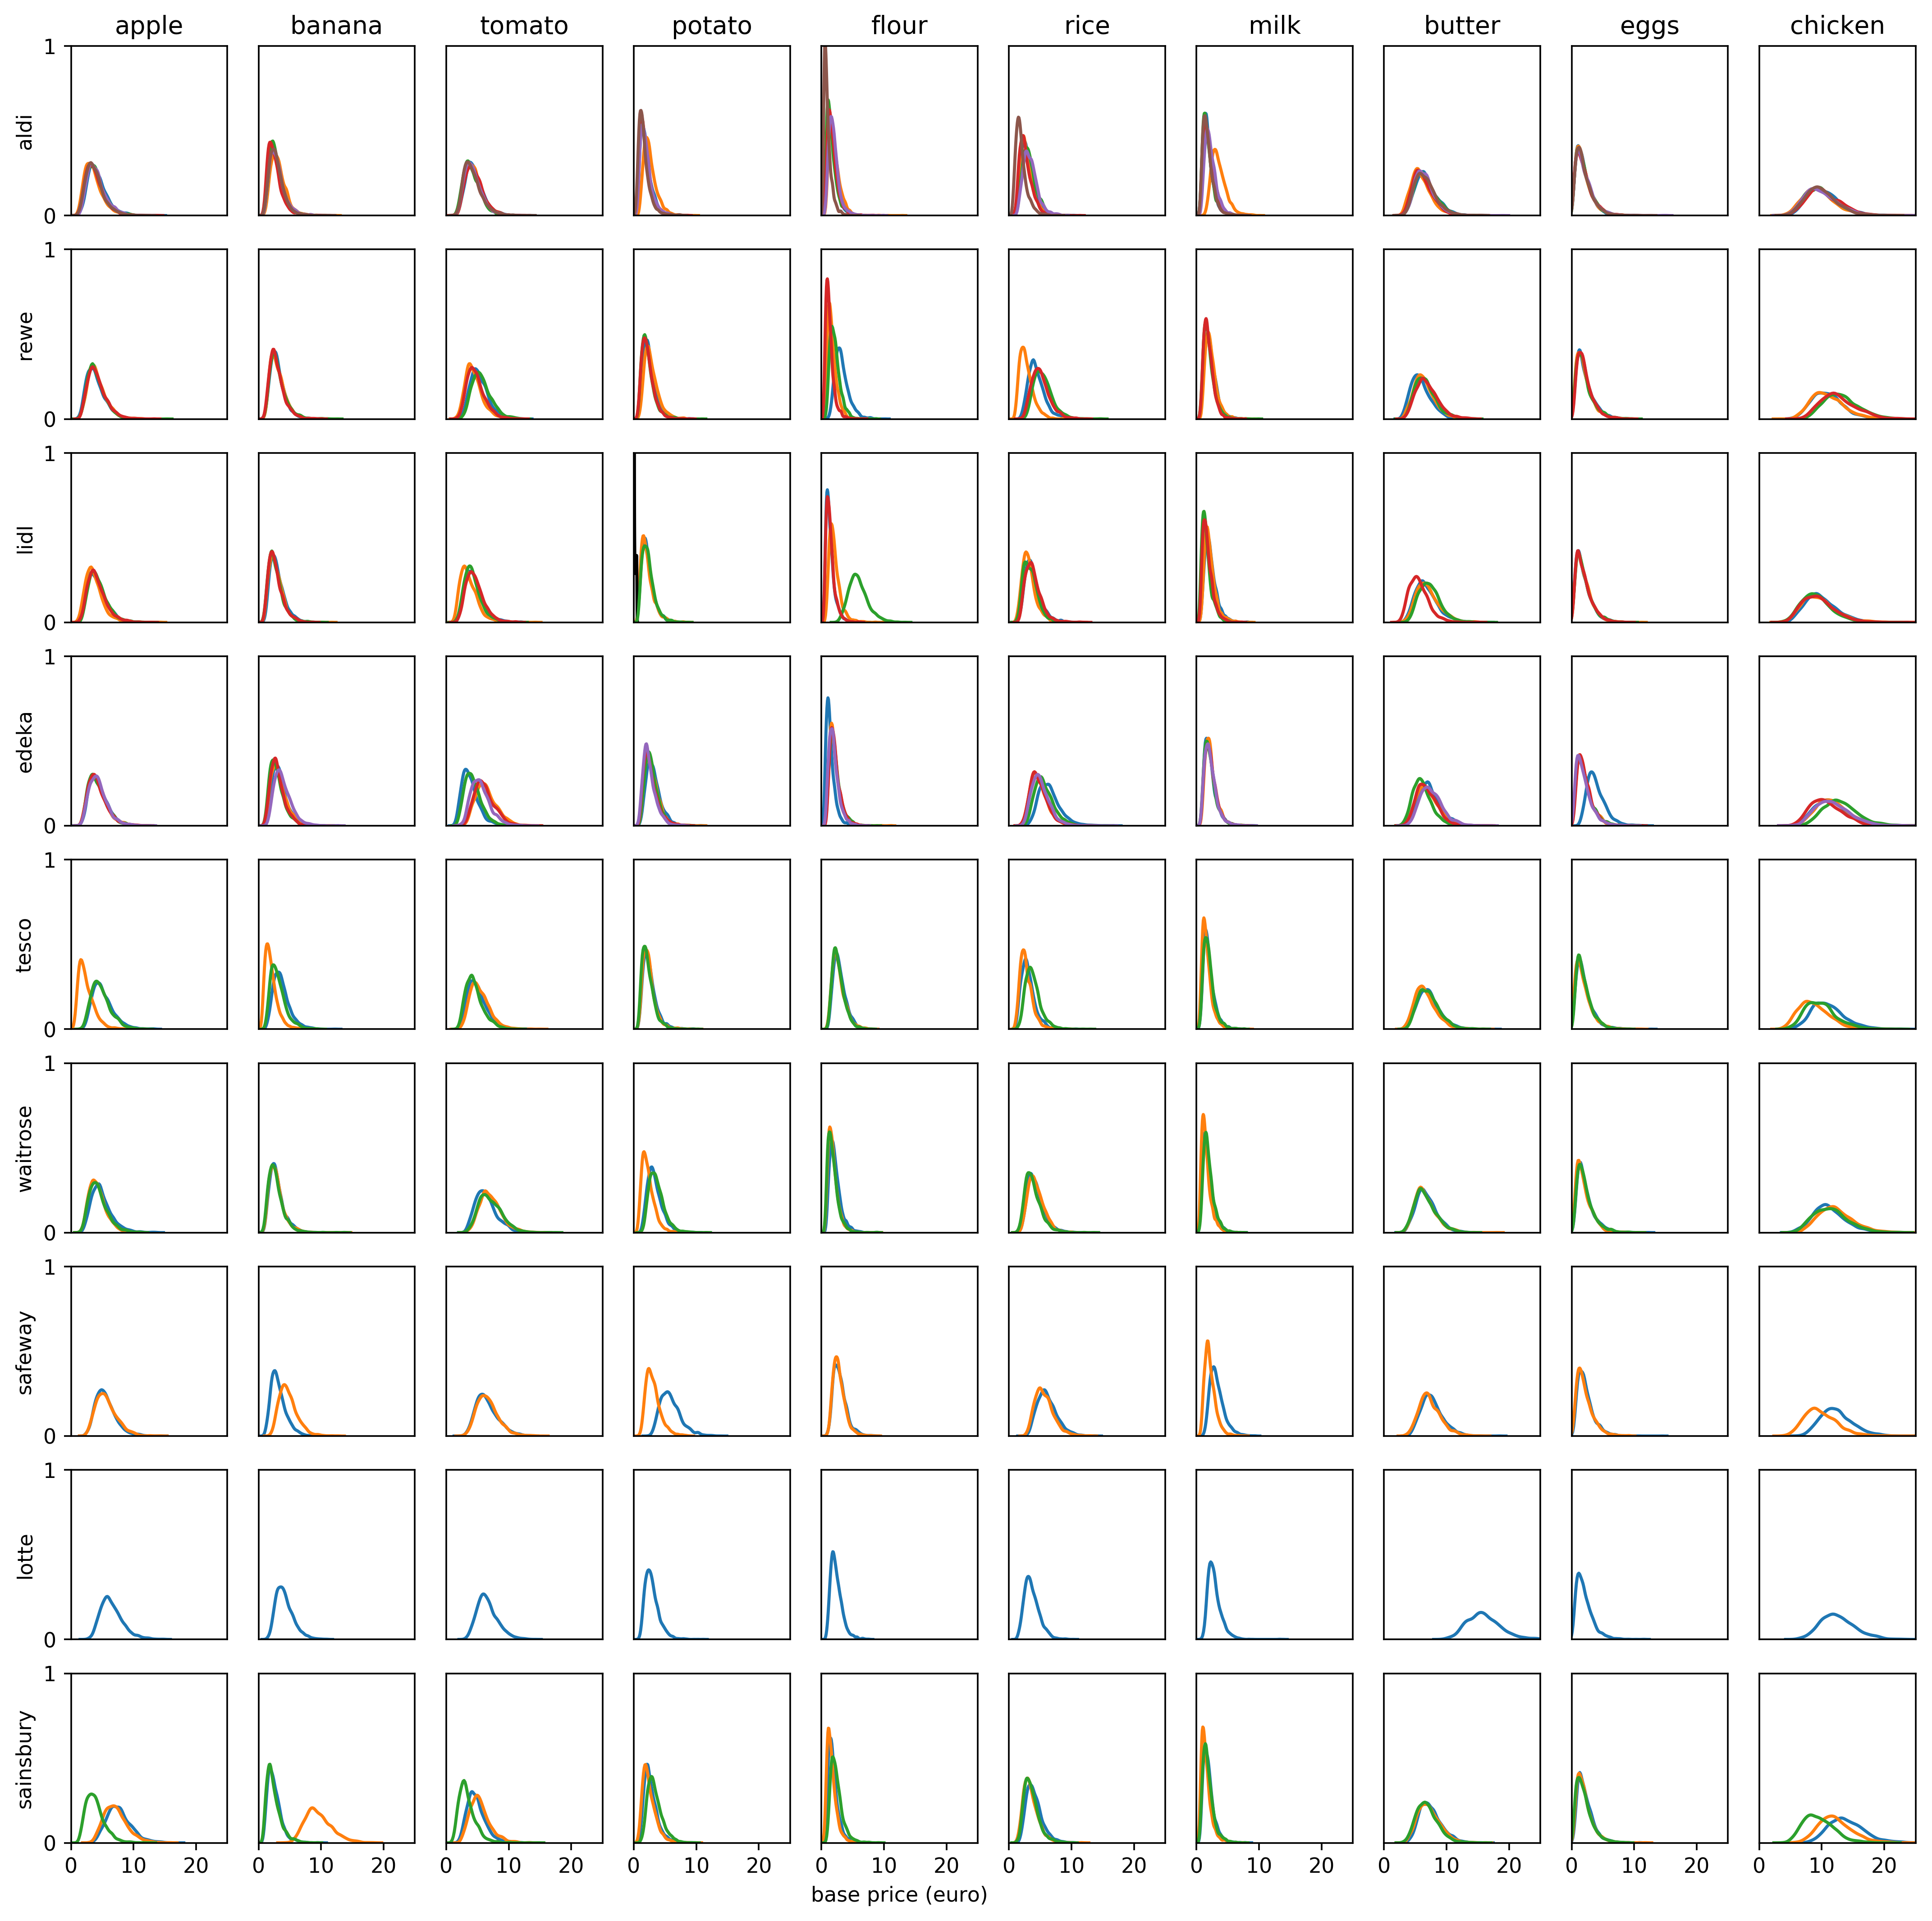

In [146]:
# 1

plt.figure(figsize=(16, 16), dpi=330)
x = np.linspace(0, 20, 200) # for "no data" cases

for prod_idx, product in enumerate(all_products): 
    for store_idx, store in enumerate(all_stores):
        plt.subplot(len(all_stores), len(all_products),
                        store_idx * len(all_products) + prod_idx + 1)
        plt.xlim((0, 25))
        plt.ylim((0, 1))
        plt.xticks([])
        plt.yticks([])
        
        if store_idx == 0:
            plt.title(product)
        elif store_idx == len(all_stores) - 1:
            plt.xticks([0, 10, 20])
            if prod_idx == 4:
                plt.xlabel('base price (euro)')
            
        if prod_idx == 0:
            plt.ylabel(store)
            plt.yticks([0, 1])
        
        for cluster in ['{0}_centroids[{1}]'.format(store, i) for i in range(num_cls_per_store[store])]:  
            if stan_results_storage[product][store][cluster]:
                sns.distplot(stan_results_storage[product][store][cluster].extract('bp')['bp'], hist=False)
            else:
                sns.distplot(sts.gamma.pdf(x, a=alpha_bps[prod_idx], scale=1/beta_bps[prod_idx]), hist=False, color='black')
            
plt.show()

* Butter in Lotte is soooo expensive haha!

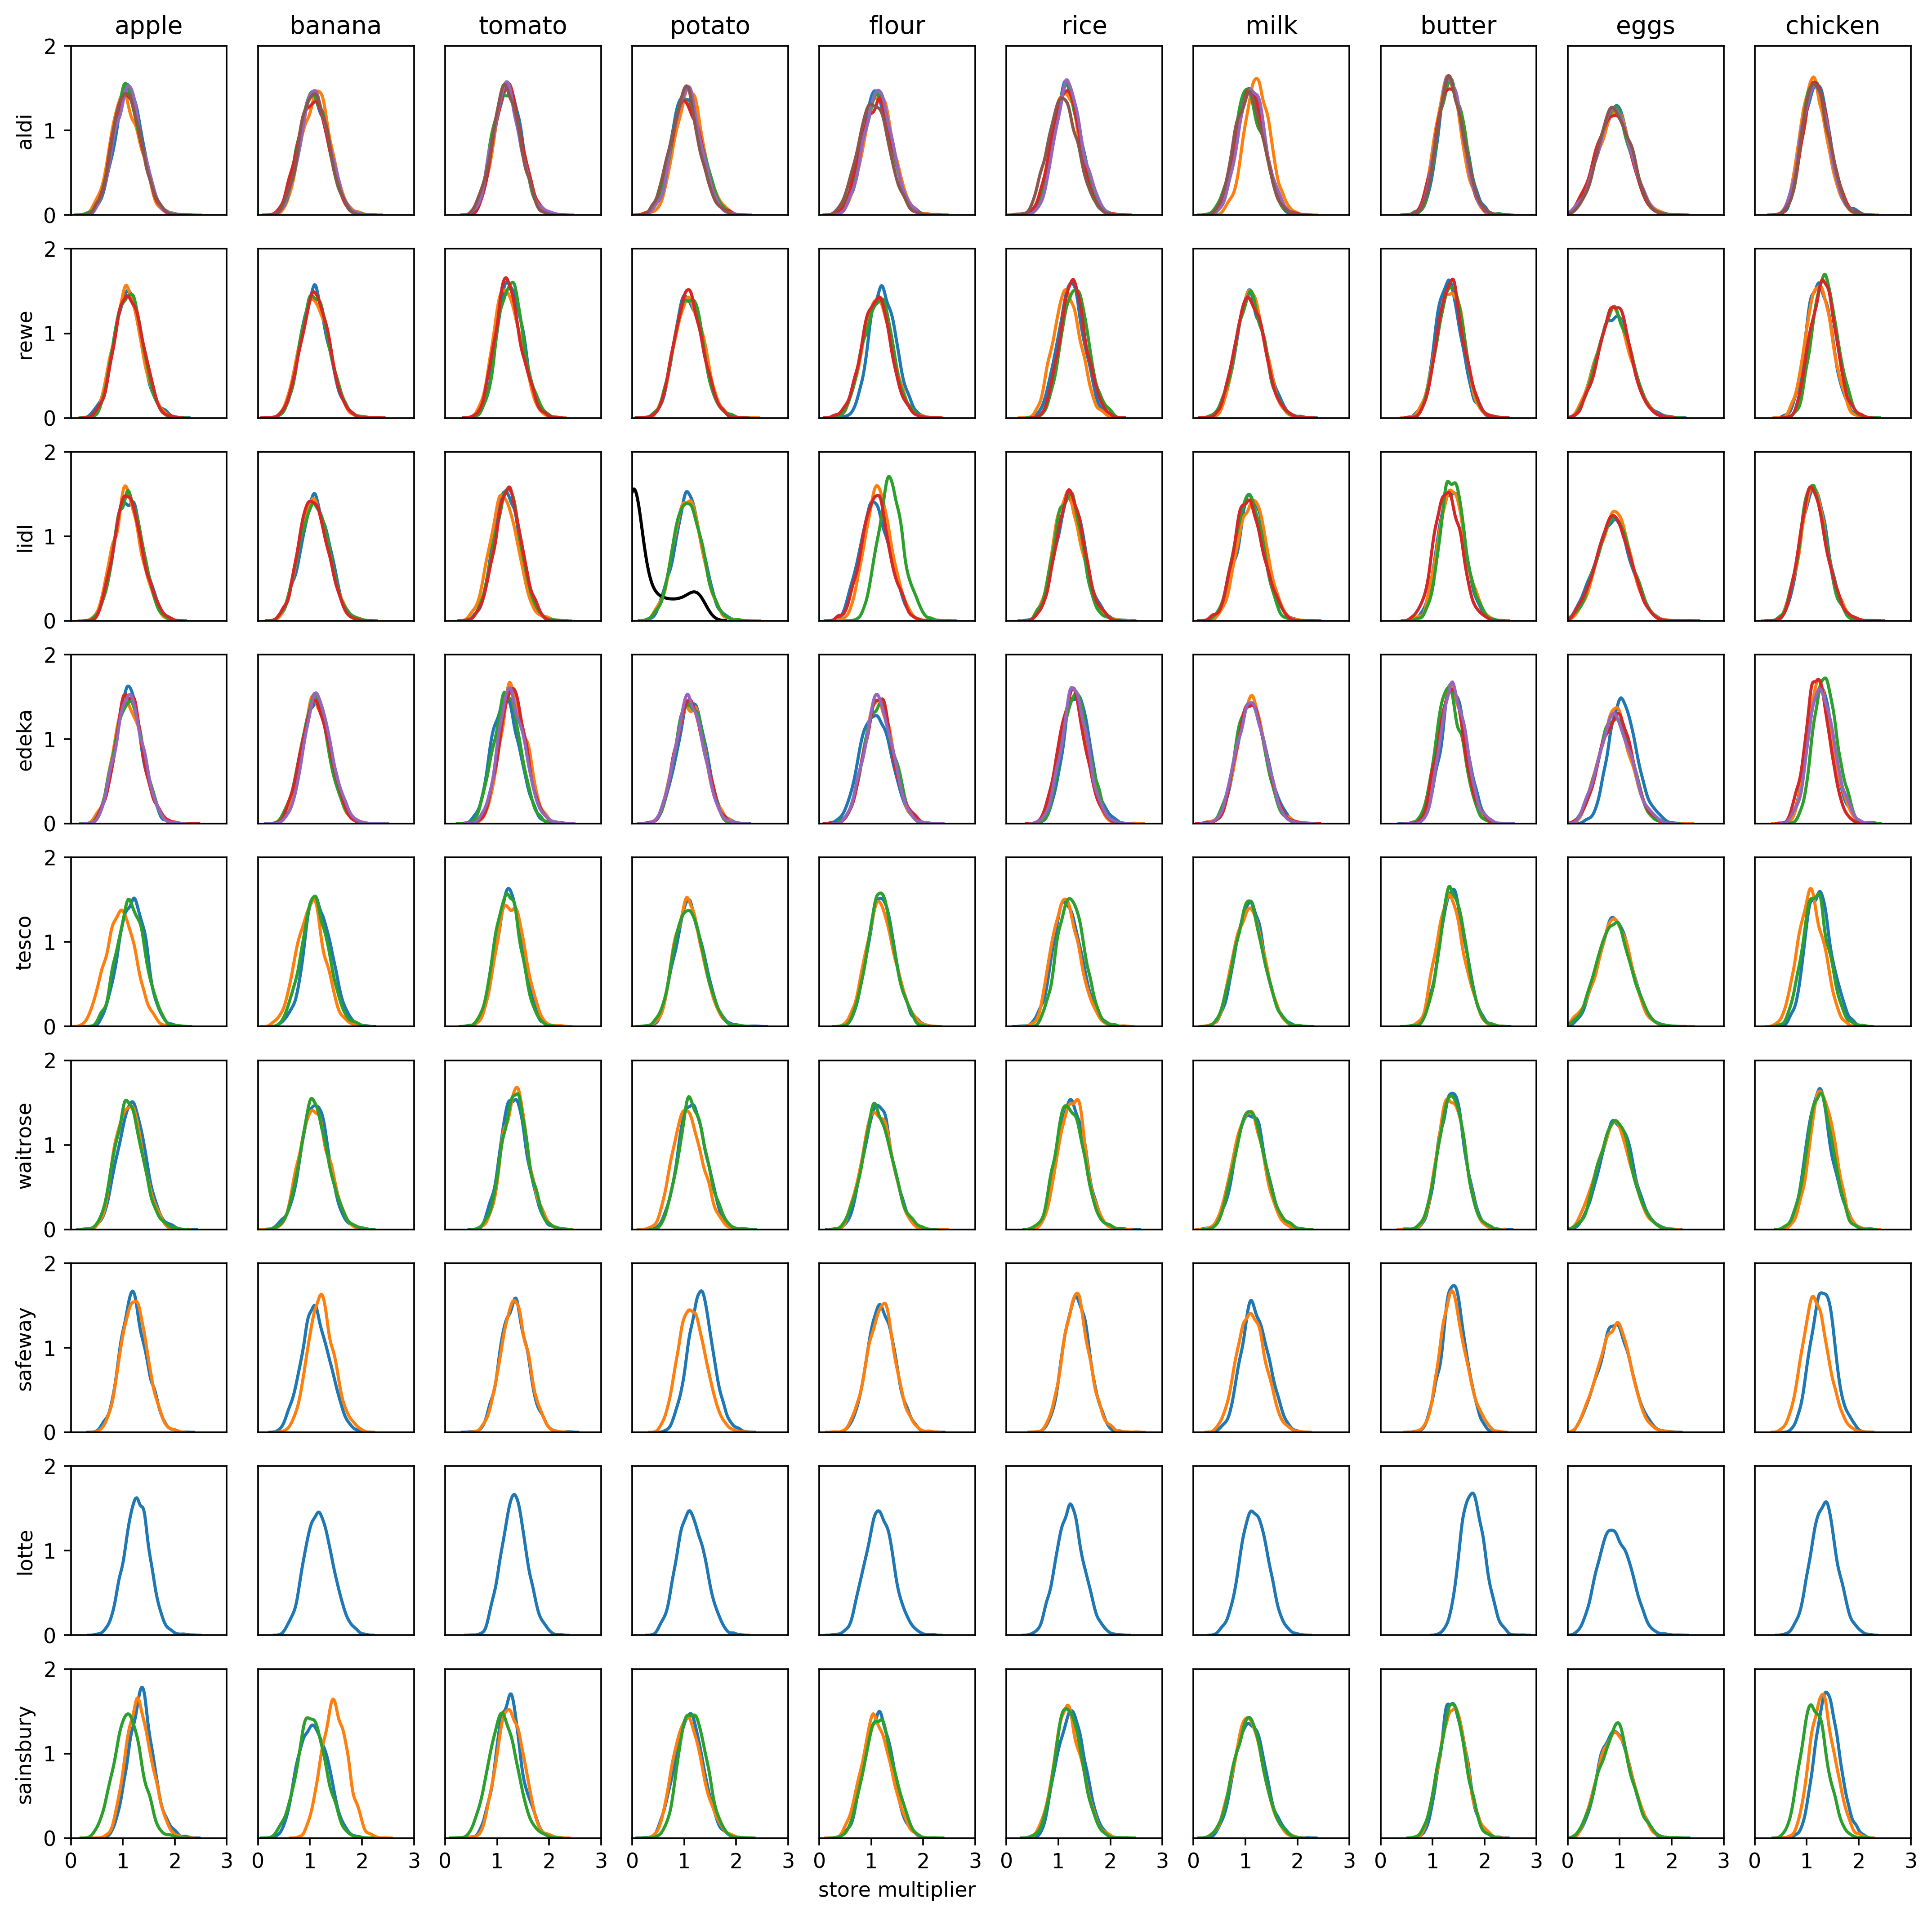

In [149]:
# 2

plt.figure(figsize=(16, 16), dpi=330)
x = np.linspace(0, 3, 200) # for "no data" cases

for prod_idx, product in enumerate(all_products): 
    for store_idx, store in enumerate(all_stores):
        plt.subplot(len(all_stores), len(all_products),
                        store_idx * len(all_products) + prod_idx + 1)
        plt.xlim((0, 3))
        plt.ylim((0, 2))
        plt.xticks([])
        plt.yticks([])
        
        if store_idx == 0:
            plt.title(product)
        elif store_idx == len(all_stores) - 1:
            plt.xticks([0, 1, 2, 3])
            if prod_idx == 4:
                plt.xlabel('store multiplier')
            
        if prod_idx == 0:
            plt.ylabel(store)
            plt.yticks([0, 1, 2])
        
        for cluster in ['{0}_centroids[{1}]'.format(store, i) for i in range(num_cls_per_store[store])]:  
            if stan_results_storage[product][store][cluster]:
                sns.distplot(stan_results_storage[product][store][cluster].extract('st_mult')['st_mult'], hist=False)
            else:
                sns.distplot(sts.norm.pdf(x, loc=mu_st_mult[prod_idx], scale=sigma_st_mult[prod_idx]), hist=False, color='black')
            
plt.show()

- Sainsbury and Tesco have quite varying distributions for most products. This means that per store cluster, the multiplier is changed quite considerably. Rewe and Edeka have varying distributions for potato and chicken -- probably these products are sourced from different suppliers at different clusters.

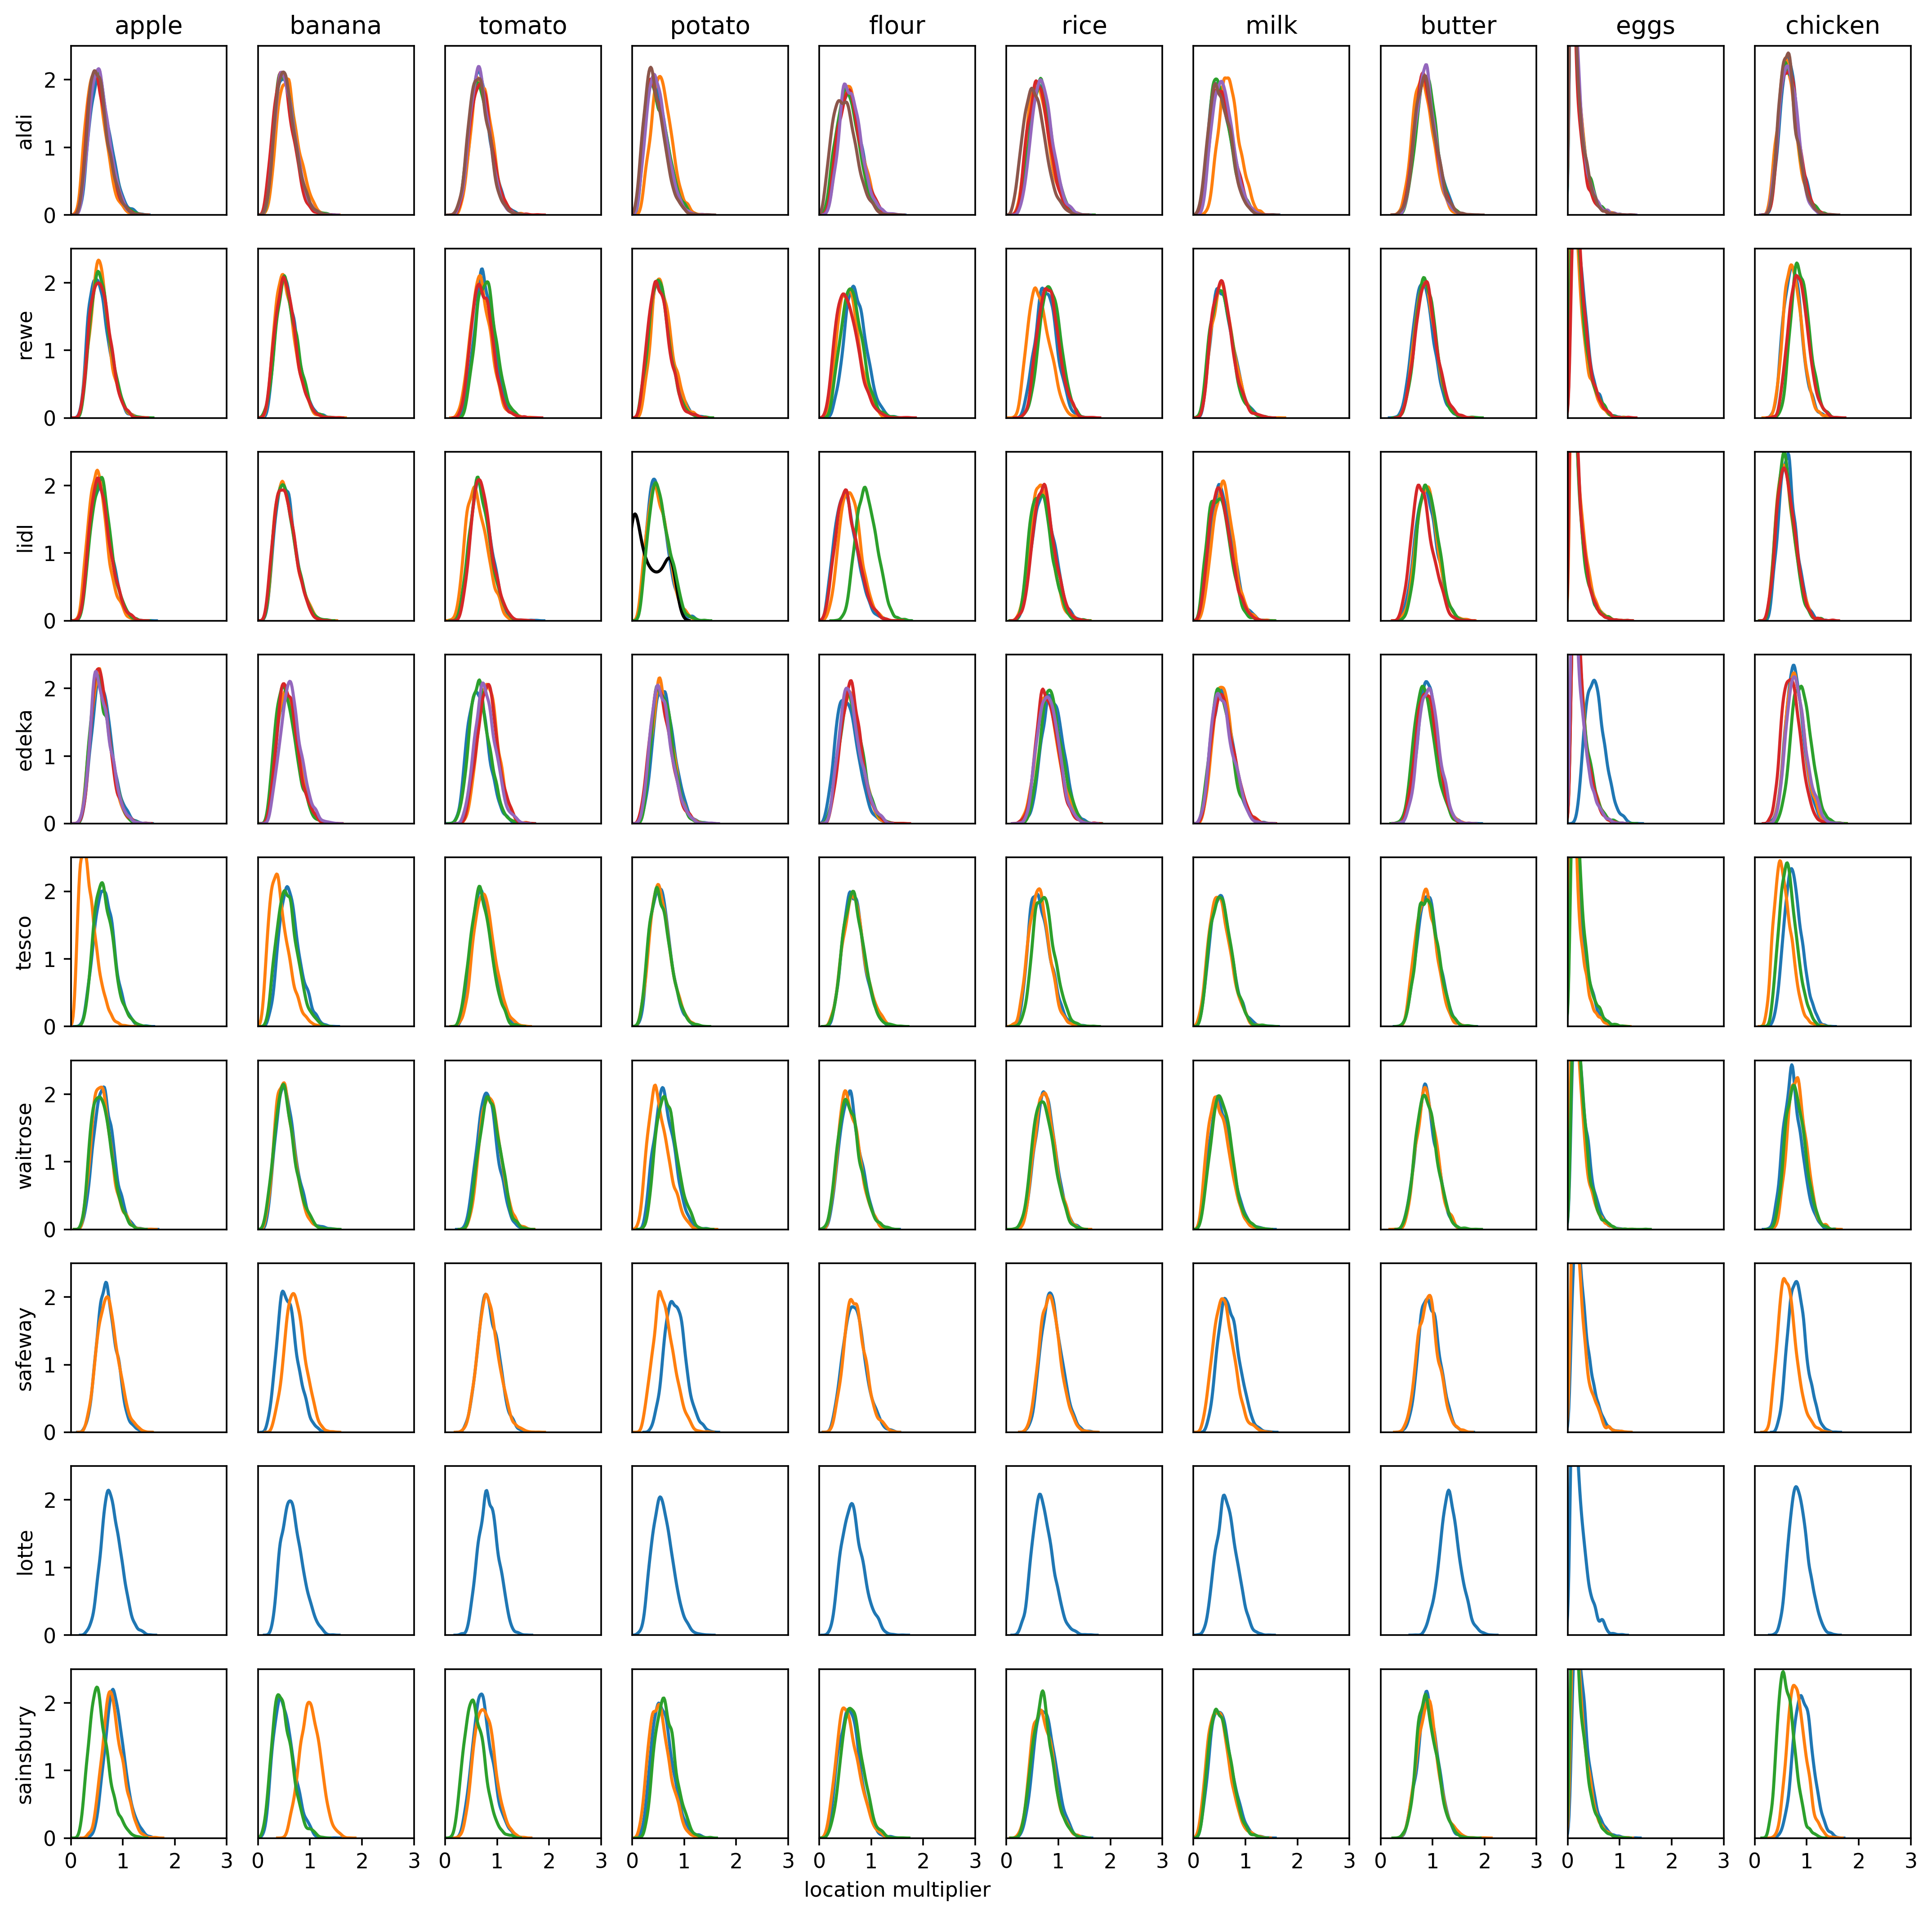

In [151]:
# 3 

plt.figure(figsize=(16, 16), dpi=330)
x = np.linspace(0, 3, 200) # for "no data" cases

for prod_idx, product in enumerate(all_products): 
    for store_idx, store in enumerate(all_stores):
        plt.subplot(len(all_stores), len(all_products),
                        store_idx * len(all_products) + prod_idx + 1)
        plt.xlim((0, 3))
        plt.ylim((0, 2.5))
        plt.xticks([])
        plt.yticks([])
        
        if store_idx == 0:
            plt.title(product)
        elif store_idx == len(all_stores) - 1:
            plt.xticks([0, 1, 2, 3])
            if prod_idx == 4:
                plt.xlabel('location multiplier')
            
        if prod_idx == 0:
            plt.ylabel(store)
            plt.yticks([0, 1, 2])
        
        for cluster in ['{0}_centroids[{1}]'.format(store, i) for i in range(num_cls_per_store[store])]:  
            if stan_results_storage[product][store][cluster]:
                sns.distplot(stan_results_storage[product][store][cluster].extract('loc_mult')['loc_mult'], hist=False)
            else:
                sns.distplot(sts.norm.pdf(x, loc=mu_loc_mult[prod_idx], scale=sigma_loc_mult[prod_idx]), hist=False, color='black')
plt.show()

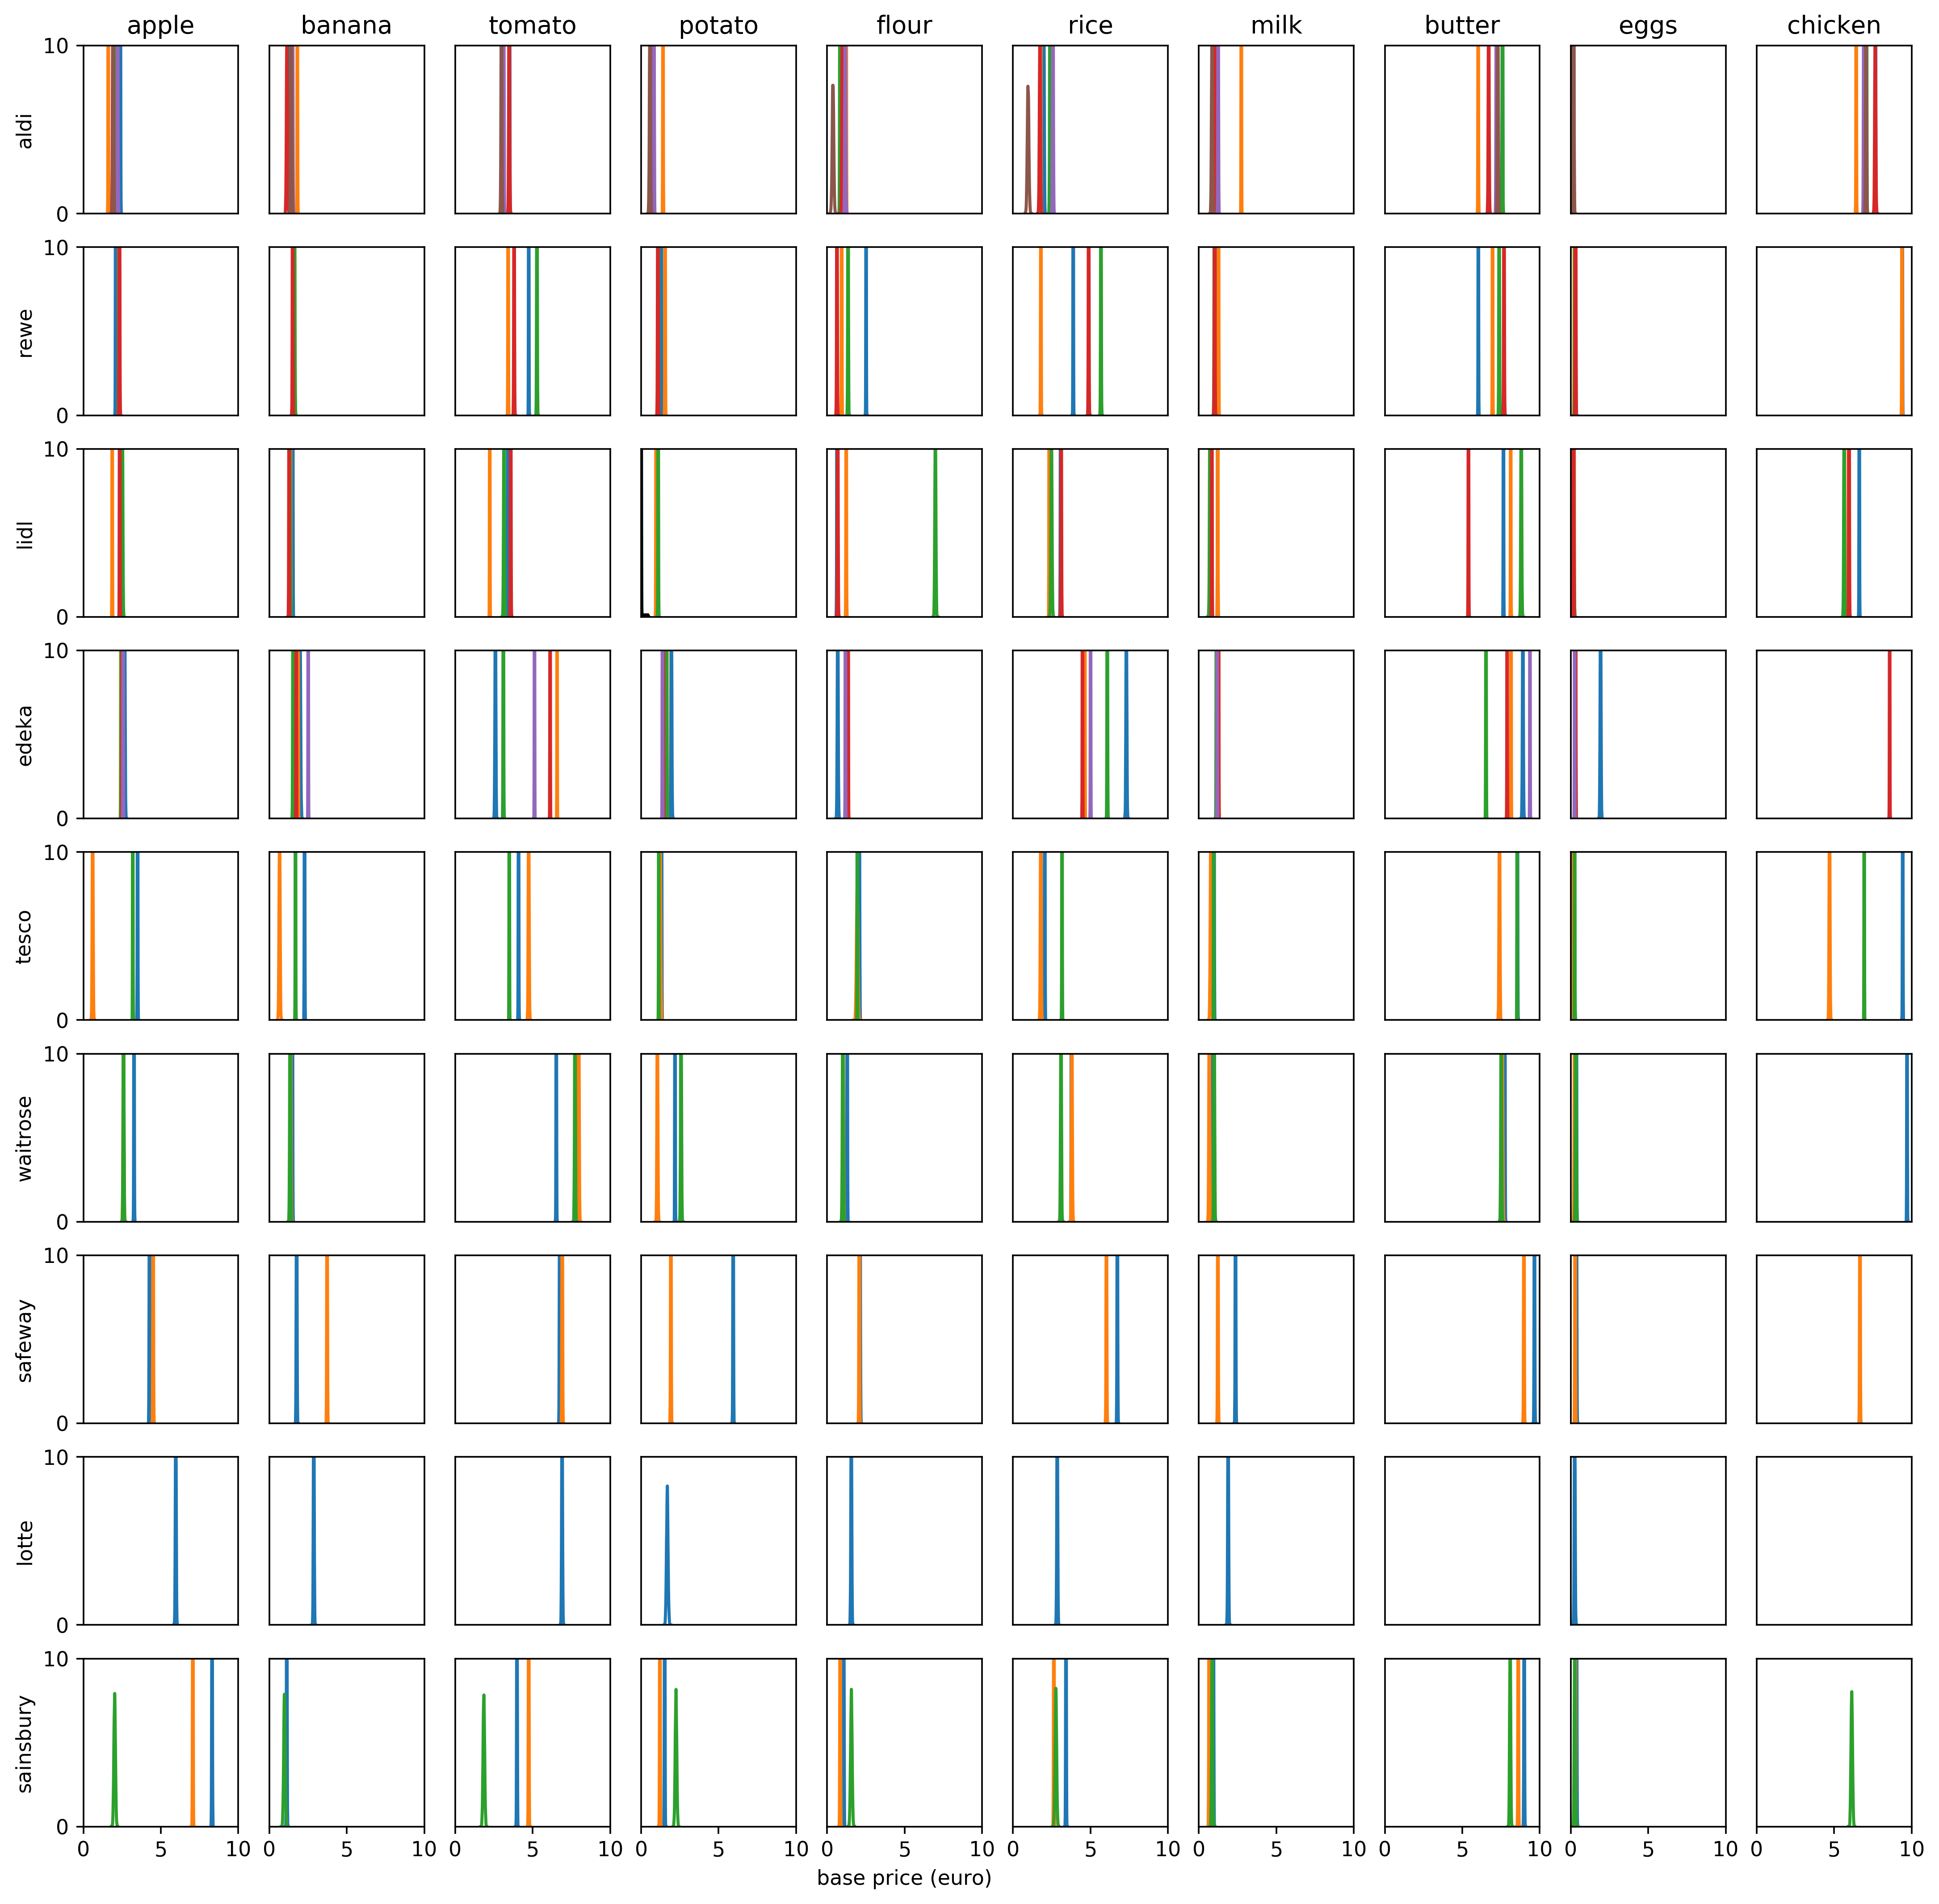

In [158]:
# 4

plt.figure(figsize=(16, 16), dpi=330)
x = np.linspace(0, 40, 200) # for posterior actual prices

for prod_idx, product in enumerate(all_products): 
    for store_idx, store in enumerate(all_stores):
        plt.subplot(len(all_stores), len(all_products),
                        store_idx * len(all_products) + prod_idx + 1)
        plt.xlim((0, 10))
        plt.ylim((0, 10))
        plt.xticks([])
        plt.yticks([])
        
        if store_idx == 0:
            plt.title(product)
        elif store_idx == len(all_stores) - 1:
            plt.xticks([0, 5, 10])
            if prod_idx == 4:
                plt.xlabel('base price (euro)')
            
        if prod_idx == 0:
            plt.ylabel(store)
            plt.yticks([0, 10])
        
        for cluster in ['{0}_centroids[{1}]'.format(store, i) for i in range(num_cls_per_store[store])]:
            if stan_results_storage[product][store][cluster]:
                bps = stan_results_storage[product][store][cluster].extract('bp')['bp']
                st_mults = stan_results_storage[product][store][cluster].extract('st_mult')['st_mult']
                loc_mults = stan_results_storage[product][store][cluster].extract('loc_mult')['loc_mult']

                aps = bps * st_mults * loc_mults
                sns.distplot(aps, hist=False)
                
            else:
                bps = sts.gamma.pdf(x, a=alpha_bps[prod_idx], scale=1/beta_bps[prod_idx])
                st_mults = sts.norm.pdf(x, loc=mu_st_mult[prod_idx], scale=sigma_st_mult[prod_idx])
                loc_mults = sts.norm.pdf(x, loc=mu_loc_mult[prod_idx], scale=sigma_loc_mult[prod_idx])
                
                aps = bps * st_mults * loc_mults
                sns.distplot(aps, hist=False, color='black')
            
plt.show()

- Combining posterior base prices, store and location multipliers, we get a posterior predictive distribution with very low variance. We still can observe difference in prices per cluster.

## Correlation
To establish correlation, we will do the following:
1. Get lat and lon for the relevant subway stations
2. Slice out Berlin stores
3. Look at normalized prices per product and compare to normalized rent prices in 3D
4. Map each store to nearest subway station, put side-by-side price of product and rental price
5. Run linear regression on product vs. rental price, check correlation coefficient `r`

In [162]:
subways = pd.read_csv(os.path.join(ROOT, 'rent_per_station.csv'))[['station', 'rent']]
subways.head(3)

station  rent
0  Lichtenberg   739
1     Neukölln   812
2        Mitte  1090

In [163]:
# 1

all_subway_locs = []

for station in subways['station']:
    station = '{0} station, Berlin'.format(station)
    all_subway_locs.append(tuple(gmaps.geocode(station)[0]['geometry']['location'].values()))

subways['lat'] = np.array(all_subway_locs)[:, 0]
subways['lon'] = np.array(all_subway_locs)[:, 1]

In [164]:
subways.head(3)

station  rent        lat        lon
0  Lichtenberg   739  52.509558  13.497257
1     Neukölln   812  52.469462  13.442058
2        Mitte  1090  52.525084  13.369402

In [169]:
# 2 

all_berlin_stores = ['aldi', 'rewe', 'lidl', 'edeka']
groceries_data_berlin = groceries_data[groceries_data['store'].isin(all_berlin_stores)]
groceries_data_berlin.head(3)

store                                  address  price_norm[0][0]  \
0  aldi                    Rummelsburger Str. 98              2.50   
1  rewe                   Karl-Marx-Straße 92-98              2.49   
2  aldi  Hermannstraße 72, 12049 Berlin, Germany              2.99   

   price_norm[0][1]  price_norm[0][2]  price_norm[1][0]  price_norm[1][1]  \
0              1.88            3.1500              1.69              0.99   
1              1.49            2.4900              0.99              1.69   
2              1.79            2.3625              1.15              1.69   

   price_norm[1][2]  price_norm[2][0]  price_norm[2][1]        ...          \
0               NaN          3.523077              2.98        ...           
1             1.590          6.900000              4.58        ...           
2             1.495          3.580000              1.99        ...           

   price_norm[7][2]  price_norm[8][0]  price_norm[8][1]  price_norm[8][2]  \
0              9.56          0.119000             0.265             0.159   
1              9.56          0.281667             0.250             0.265   
2              5.16          0.159000             0.119             0.265   

   price_norm[9][0]  price_norm[9][1]  price_norm[9][2]        lat        lon  \
0              6.65              5.99               NaN  52.499561  13.495014   
1             13.90              9.99              9.98  52.479877  13.435877   
2              6.65              5.99             11.40  52.474060  13.427420   

             cluster  
0  aldi_centroids[4]  
1  rewe_centroids[0]  
2  aldi_centroids[2]  

[3 rows x 35 columns]

In [170]:
# 3 Didn't have enough time to complete :(